# BRCA Histological Type Classification

Predicting breast cancer histological subtype (ductal vs. lobular) from multi-omic measurements.

## Workflow
1. Import libraries
2. Load and inspect data
3. Preprocess features
4. PCA transformation (dimensionality reduction)
5. Model training with hyperparameter tuning (Logistic Regression)
6. Evaluation and interpretation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import time
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ Libraries imported successfully!')

✅ Libraries imported successfully!


## 1. Load and Explore Data

In [3]:
DATA_PATH = 'brca_data_w_subtypes.csv'
TARGET_COLUMN = 'histological.type'

df = pd.read_csv(DATA_PATH)

print('='*80)
print('DATASET OVERVIEW')
print('='*80)
print(f'Dataset shape: {df.shape}')
print(f'Total samples: {len(df):,}')
print(f'Total columns: {len(df.columns):,}')
print(f'Target column: {TARGET_COLUMN}')
print(f'First 5 feature columns: {df.columns[:5].tolist()}')
print(f'Last 5 columns: {df.columns[-5:].tolist()}')

display(df.head())

DATASET OVERVIEW
Dataset shape: (705, 1941)
Total samples: 705
Total columns: 1,941
Target column: histological.type
First 5 feature columns: ['rs_CLEC3A', 'rs_CPB1', 'rs_SCGB2A2', 'rs_SCGB1D2', 'rs_TFF1']
Last 5 columns: ['vital.status', 'PR.Status', 'ER.Status', 'HER2.Final.Status', 'histological.type']


,rs_CLEC3A,rs_CPB1,rs_SCGB2A2,rs_SCGB1D2,rs_TFF1,rs_MUCL1,rs_GSTM1,rs_PIP,rs_ADIPOQ,rs_ADH1B,...,pp_p62.LCK.ligand,pp_p70S6K,pp_p70S6K.pT389,pp_p90RSK,pp_p90RSK.pT359.S363,vital.status,PR.Status,ER.Status,HER2.Final.Status,histological.type
0,0.892818,6.580103,14.123672,10.606501,13.189237,6.649466,10.520335,10.338490,10.248379,10.229970,...,-0.691766,-0.337863,-0.178503,0.011638,-0.207257,0,Positive,Positive,Negative,infiltrating ductal carcinoma
1,0.000000,3.691311,17.116090,15.517231,9.867616,9.691667,8.179522,7.911723,1.289598,1.818891,...,0.279067,0.292925,-0.155242,-0.089365,0.267530,0,Positive,Negative,Negative,infiltrating ductal carcinoma
2,3.748150,4.375255,9.658123,5.326983,12.109539,11.644307,10.517330,5.114925,11.975349,11.911437,...,0.219910,0.308110,-0.190794,-0.222150,-0.198518,0,Positive,Positive,Negative,infiltrating ductal carcinoma
3,0.000000,18.235519,18.535480,14.533584,14.078992,8.913760,10.557465,13.304434,8.205059,9.211476,...,-0.266554,-0.079871,-0.463237,0.522998,-0.046902,0,Positive,Positive,Negative,infiltrating ductal carcinoma
4,0.000000,4.583724,15.711865,12.804521,8.881669,8.430028,12.964607,6.806517,4.294341,5.385714,...,-0.441542,-0.152317,0.511386,-0.096482,0.037473,0,Positive,Positive,Negative,infiltrating ductal carcinoma



TARGET DISTRIBUTION
histological.type
infiltrating ductal carcinoma     574
infiltrating lobular carcinoma    131
Name: count, dtype: int64

Class proportions:
histological.type
infiltrating ductal carcinoma     0.814
infiltrating lobular carcinoma    0.186
Name: count, dtype: float64


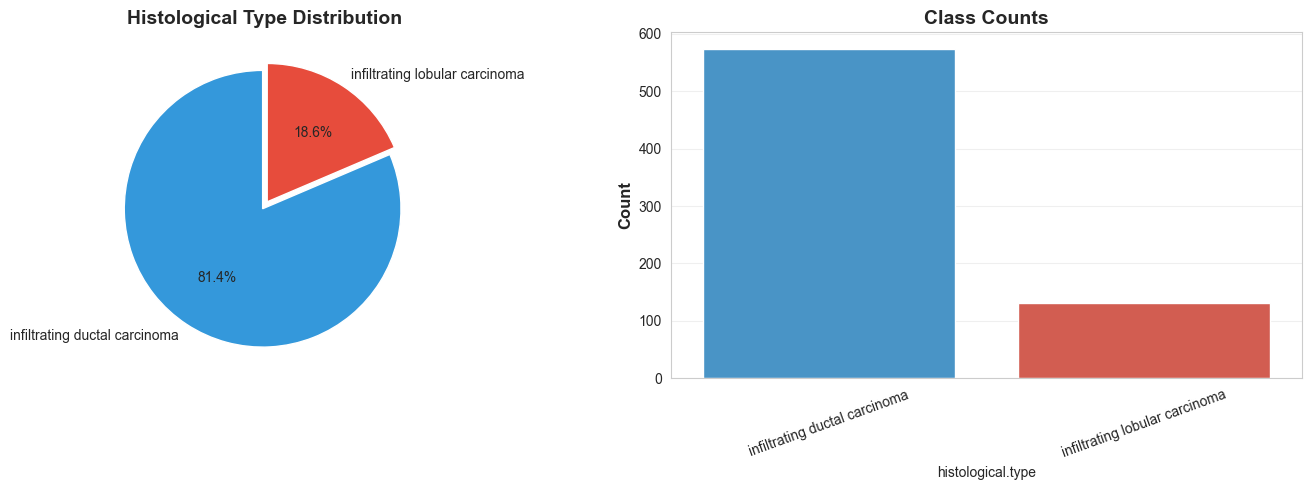

In [4]:
# Target distribution
value_counts = df[TARGET_COLUMN].value_counts()
print('\n' + '='*80)
print('TARGET DISTRIBUTION')
print('='*80)
print(value_counts)
print('\nClass proportions:')
print((value_counts / len(df)).round(3))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, explode=[0.03]*len(value_counts), colors=['#3498db', '#e74c3c'])
axes[0].set_title('Histological Type Distribution', fontsize=14, weight='bold')

sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[1], palette=['#3498db', '#e74c3c'])
axes[1].set_ylabel('Count', fontsize=12, weight='bold')
axes[1].set_title('Class Counts', fontsize=14, weight='bold')
axes[1].tick_params(axis='x', rotation=20)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# Missing value analysis
missing_total = df.isnull().sum().sum()
missing_percent = missing_total / (df.shape[0] * df.shape[1]) * 100

print('\n' + '='*80)
print('MISSING VALUE ANALYSIS')
print('='*80)
print(f'Total missing values: {missing_total:,}')
print(f'Percent missing: {missing_percent:.2f}%')

if missing_total > 0:
    cols_with_missing = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
    print(f'Columns with missing values: {len(cols_with_missing)}')
    display(cols_with_missing.head(10))


MISSING VALUE ANALYSIS
Total missing values: 389
Percent missing: 0.03%
Columns with missing values: 3


HER2.Final.Status    145
PR.Status            122
ER.Status            122
dtype: int64

## 2. Data Preprocessing

In [6]:
# Median imputation for numeric columns
print('='*80)
print('PREPROCESSING: IMPUTATION')
print('='*80)
print(f'Missing values before: {missing_total:,}')
df_clean = df.fillna(df.median(numeric_only=True))
print(f'Missing values after: {df_clean.isnull().sum().sum():,}')
print('\n✅ Numeric features imputed with median values.')

PREPROCESSING: IMPUTATION
Missing values before: 389
Missing values after: 389

✅ Numeric features imputed with median values.
Missing values after: 389

✅ Numeric features imputed with median values.


In [7]:
# Feature matrix and target vector
# Define columns to exclude (target + clinical status columns that could cause data leakage)
exclude_cols = [
    TARGET_COLUMN,
    'PR.Status',           # Progesterone receptor status (clinical label)
    'ER.Status',           # Estrogen receptor status (clinical label)
    'HER2.Final.Status',   # HER2 status (clinical label)
    'vital.status'         # Patient outcome (not relevant for histological prediction)
]

# Remove excluded columns that actually exist in the dataset
exclude_cols = [col for col in exclude_cols if col in df_clean.columns]
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

print('='*80)
print('EXCLUDED COLUMNS (Prevent Data Leakage)')
print('='*80)
print(f'Excluding {len(exclude_cols)} columns:')
for col in exclude_cols:
    if col != TARGET_COLUMN:
        print(f'  - {col}: Clinical label/outcome variable')
print(f'  - {TARGET_COLUMN}: Target variable')

X = df_clean[feature_cols]
y = df_clean[TARGET_COLUMN]

# Check data types and identify non-numeric columns
print('\n' + '='*80)
print('DATA TYPE ANALYSIS')
print('='*80)
non_numeric_cols = X.select_dtypes(include=['object']).columns.tolist()
if non_numeric_cols:
    print(f'Found {len(non_numeric_cols)} non-numeric columns:')
    for col in non_numeric_cols[:10]:  # Show first 10
        print(f'  - {col}: {X[col].unique()[:5].tolist()}')
    print(f'\nRemoving {len(non_numeric_cols)} non-numeric columns...')
    X = X.select_dtypes(include=[np.number])
    print(f'Remaining numeric features: {X.shape[1]}')
else:
    print('All features are numeric.')

print('\n' + '='*80)
print('FEATURE / TARGET SHAPES')
print('='*80)
print(f'Feature matrix: {X.shape}')
print(f'Target vector: {y.shape}')

EXCLUDED COLUMNS (Prevent Data Leakage)
Excluding 5 columns:
  - PR.Status: Clinical label/outcome variable
  - ER.Status: Clinical label/outcome variable
  - HER2.Final.Status: Clinical label/outcome variable
  - vital.status: Clinical label/outcome variable
  - histological.type: Target variable

DATA TYPE ANALYSIS
All features are numeric.

FEATURE / TARGET SHAPES
Feature matrix: (705, 1936)
Target vector: (705,)


In [8]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=3
)

print('='*80)
print('TRAIN / TEST SPLIT')
print('='*80)
print(f'Train samples: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)')
print(f'Test samples:  {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)')
print('\nTrain distribution:')
print(y_train.value_counts())
print('\nTest distribution:')
print(y_test.value_counts())

TRAIN / TEST SPLIT
Train samples: 564 (80.0%)
Test samples:  141 (20.0%)

Train distribution:
histological.type
infiltrating ductal carcinoma     459
infiltrating lobular carcinoma    105
Name: count, dtype: int64

Test distribution:
histological.type
infiltrating ductal carcinoma     115
infiltrating lobular carcinoma     26
Name: count, dtype: int64


In [9]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('='*80)
print('SCALING SUMMARY')
print('='*80)
print(f'Scaled train shape: {X_train_scaled.shape}')
print(f'Scaled test shape:  {X_test_scaled.shape}')
print(f'Mean (approx): {X_train_scaled.mean():.4f}')
print(f'Std (approx):  {X_train_scaled.std():.4f}')

SCALING SUMMARY
Scaled train shape: (564, 1936)
Scaled test shape:  (141, 1936)
Mean (approx): -0.0000
Std (approx):  1.0000


## 3. PCA Transformation

In [10]:
# Variance threshold to drop near-constant features
var_selector = VarianceThreshold(threshold=0.01)
X_train_var = var_selector.fit_transform(X_train_scaled)
X_test_var = var_selector.transform(X_test_scaled)
selected_feature_indices = var_selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_feature_indices]

removed = X_train_scaled.shape[1] - X_train_var.shape[1]
print('='*80)
print('VARIANCE THRESHOLD RESULTS')
print('='*80)
print(f'Original features: {X_train_scaled.shape[1]:,}')
print(f'Remaining features: {X_train_var.shape[1]:,}')
print(f'Removed low-variance features: {removed:,}')

VARIANCE THRESHOLD RESULTS
Original features: 1,936
Remaining features: 1,936
Removed low-variance features: 0


PCA ANALYSIS
Total components: 564
Components for 95% variance: 325
Variance explained by PC1: 0.0850
Variance explained by PC2: 0.0615
Cumulative variance (PC1+PC2): 0.1465

USING PCA COMPONENTS FOR LOGISTIC REGRESSION
PCA components (95% variance): 325
These 325 components will be used directly in the model
Benefits: Decorrelated features, optimal for linear models


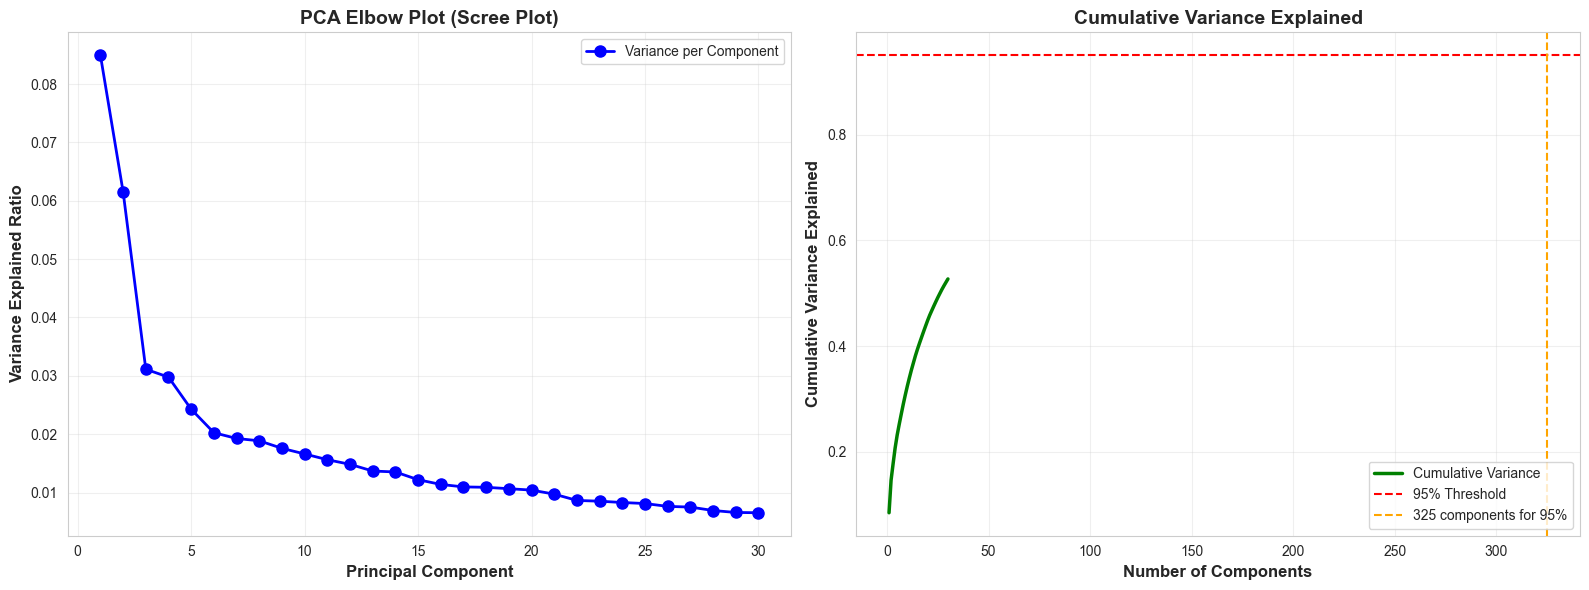

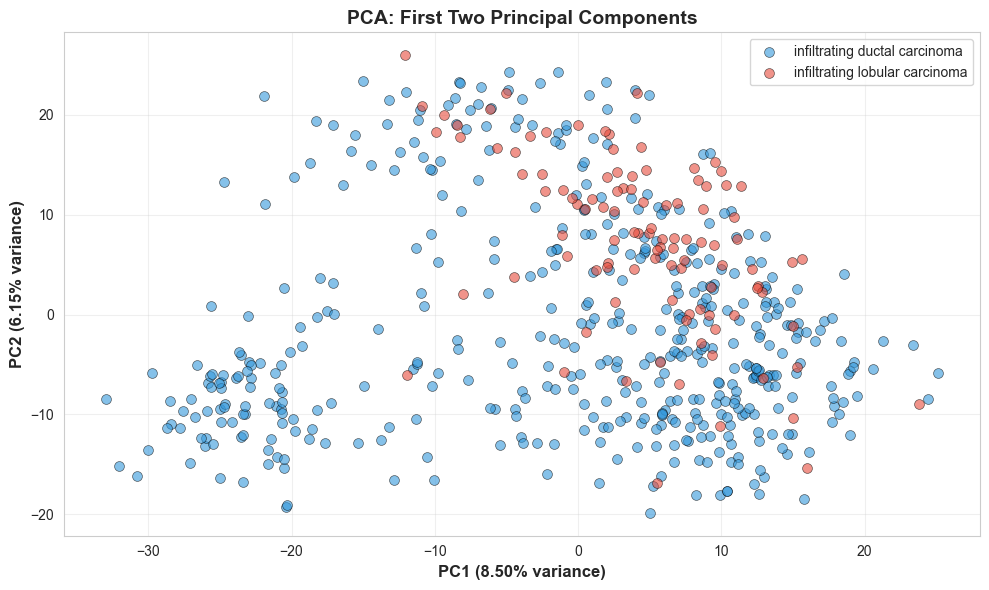

In [12]:
# PCA Analysis - Transform data to PCA components
from sklearn.decomposition import PCA

# Fit PCA on all variance-filtered features
pca = PCA(random_state=3)
X_train_pca = pca.fit_transform(X_train_var)
X_test_pca = pca.transform(X_test_var)

# Calculate cumulative variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print('='*80)
print('PCA ANALYSIS')
print('='*80)
print(f'Total components: {len(pca.explained_variance_ratio_)}')
print(f'Components for 95% variance: {n_components_95}')
print(f'Variance explained by PC1: {pca.explained_variance_ratio_[0]:.4f}')
print(f'Variance explained by PC2: {pca.explained_variance_ratio_[1]:.4f}')
print(f'Cumulative variance (PC1+PC2): {cumulative_variance[1]:.4f}')

print('\n' + '='*80)
print(f'USING PCA COMPONENTS FOR LOGISTIC REGRESSION')
print('='*80)
print(f'PCA components (95% variance): {n_components_95}')
print(f'These {n_components_95} components will be used directly in the model')
print('Benefits: Decorrelated features, optimal for linear models')
print('='*80)

# Elbow Plot (Scree Plot)
n_components_to_show = min(30, len(pca.explained_variance_ratio_))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot - variance explained by each component
axes[0].plot(range(1, n_components_to_show + 1), 
             pca.explained_variance_ratio_[:n_components_to_show], 
             'bo-', linewidth=2, markersize=8, label='Variance per Component')
axes[0].set_xlabel('Principal Component', fontsize=12, weight='bold')
axes[0].set_ylabel('Variance Explained Ratio', fontsize=12, weight='bold')
axes[0].set_title('PCA Elbow Plot (Scree Plot)', fontsize=14, weight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend(loc='upper right')

# Cumulative variance curve
axes[1].plot(range(1, n_components_to_show + 1), 
             cumulative_variance[:n_components_to_show], 
             'g-', linewidth=2.5, label='Cumulative Variance')
axes[1].axhline(y=0.95, color='r', linestyle='--', linewidth=1.5, label='95% Threshold')
axes[1].axvline(x=n_components_95, color='orange', linestyle='--', linewidth=1.5, 
                label=f'{n_components_95} components for 95%')
axes[1].set_xlabel('Number of Components', fontsize=12, weight='bold')
axes[1].set_ylabel('Cumulative Variance Explained', fontsize=12, weight='bold')
axes[1].set_title('Cumulative Variance Explained', fontsize=14, weight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Optional: 2D scatter plot
colors_map = {'infiltrating ductal carcinoma': '#3498db', 'infiltrating lobular carcinoma': '#e74c3c'}
plt.figure(figsize=(10, 6))
for label in y_train.unique():
    mask = y_train == label
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], 
               c=colors_map[label], label=label, alpha=0.6, s=50, edgecolors='k', linewidth=0.5)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12, weight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12, weight='bold')
plt.title('PCA: First Two Principal Components', fontsize=14, weight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Hyperparameter Tuning

In [ ]:
# Reduce PCA to 95% variance components
X_train_pca_reduced = X_train_pca[:, :n_components_95]
X_test_pca_reduced = X_test_pca[:, :n_components_95]

print('='*80)
print('PCA DIMENSIONALITY REDUCTION')
print('='*80)
print(f'Original PCA components: {X_train_pca.shape[1]}')
print(f'Reduced to (95% variance): {n_components_95}')
print(f'Train shape: {X_train_pca_reduced.shape}')
print(f'Test shape: {X_test_pca_reduced.shape}')

# Pipeline: SMOTE + Logistic Regression on PCA components
# Using imbalanced-learn pipeline to include SMOTE
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=3)),
    ('classifier', LogisticRegression(random_state=3, max_iter=2000))
])

# Hyperparameter grid for Logistic Regression (Balanced for 4-5 min runtime)
param_grid = {
    'smote__k_neighbors': [3, 5, 7],  # SMOTE neighbors parameter
    'smote__sampling_strategy': [0.5, 0.75, 1.0],  # How much to oversample minority class
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength (full range)
    'classifier__penalty': ['l2'],  # L2 regularization (fastest, still effective)
    'classifier__solver': ['lbfgs'],  # Fast solver for L2
    'classifier__class_weight': [
        None,
        'balanced',  # Auto weight: n_samples / (n_classes * np.bincount(y))
        {"infiltrating ductal carcinoma": 1, "infiltrating lobular carcinoma": 4.38}  # Exact ratio
    ]
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv_strategy,
    verbose=1,  # Reduced verbosity
    n_jobs=-1,
    return_train_score=True
)

print('\n' + '='*80)
print('LOGISTIC REGRESSION WITH PCA COMPONENTS')
print('='*80)
print(f'Using {n_components_95} PCA components (95% variance)')
print('SMOTE oversampling + class weights for imbalance handling')
print('Tuning: SMOTE parameters, C (regularization), and class weights')
print(f'Total parameter combinations: 3 SMOTE_k × 3 sampling × 6 C × 3 weights = 162 combinations')
print(f'With 5-fold CV: 162 × 5 = 810 model fits (~4-5 minutes)')
print('='*80)

start_time = time.time()
grid_search.fit(X_train_pca_reduced, y_train)
tuning_time = time.time() - start_time

print('\n' + '='*80)
print('BEST HYPERPARAMETERS')
print('='*80)
print(f'Best CV ROC-AUC: {grid_search.best_score_:.4f}')
print(f'Total tuning time: {tuning_time/60:.2f} minutes')
for param, value in grid_search.best_params_.items():
    print(f'  {param}: {value}')

tuned_model = grid_search.best_estimator_

PCA DIMENSIONALITY REDUCTION
Original PCA components: 564
Reduced to (95% variance): 325
Train shape: (564, 325)
Test shape: (141, 325)

LOGISTIC REGRESSION WITH PCA COMPONENTS
Using 325 PCA components (95% variance)
SMOTE oversampling + class weights for imbalance handling
Tuning: SMOTE parameters, C (regularization), and class weights
Total parameter combinations: 3 SMOTE_k × 3 sampling × 6 C × 3 weights = 162 combinations
With 5-fold CV: 162 × 5 = 810 model fits (~4-5 minutes)
Fitting 5 folds for each of 162 candidates, totalling 810 fits

BEST HYPERPARAMETERS
Best CV ROC-AUC: 0.9201
Total tuning time: 0.12 minutes
  classifier__C: 0.01
  classifier__class_weight: None
  classifier__penalty: l2
  classifier__solver: lbfgs
  smote__k_neighbors: 5
  smote__sampling_strategy: 0.5

BEST HYPERPARAMETERS
Best CV ROC-AUC: 0.9201
Total tuning time: 0.12 minutes
  classifier__C: 0.01
  classifier__class_weight: None
  classifier__penalty: l2
  classifier__solver: lbfgs
  smote__k_neighbors: 

## 5. Evaluation

In [ ]:
# Predictions and metrics
y_pred = tuned_model.predict(X_test_pca_reduced)
y_pred_proba = tuned_model.predict_proba(X_test_pca_reduced)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score((y_test == 'infiltrating lobular carcinoma').astype(int), y_pred_proba)

print('='*80)
print('TEST PERFORMANCE (TUNED LOGISTIC REGRESSION)')
print('='*80)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro): {recall_macro:.4f}')
print(f'F1-score (macro): {f1_macro:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')

print('\nClassification report:')
print(classification_report(y_test, y_pred))

TEST PERFORMANCE (TUNED LOGISTIC REGRESSION)
Accuracy: 0.9220
Precision (macro): 0.8670
Recall (macro): 0.8778
F1-score (macro): 0.8722
ROC-AUC: 0.9559

Classification report:
                                precision    recall  f1-score   support

 infiltrating ductal carcinoma       0.96      0.95      0.95       115
infiltrating lobular carcinoma       0.78      0.81      0.79        26

                      accuracy                           0.92       141
                     macro avg       0.87      0.88      0.87       141
                  weighted avg       0.92      0.92      0.92       141



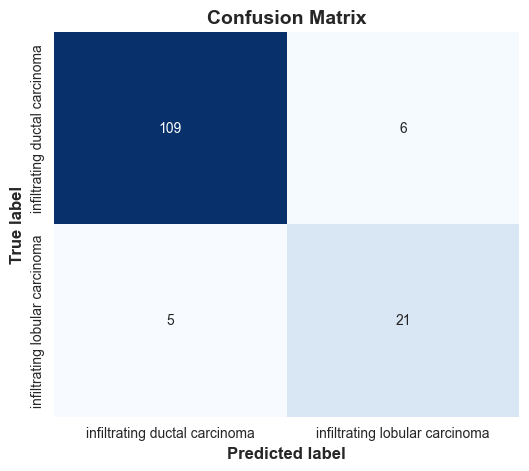

In [ ]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred, labels=value_counts.index)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=value_counts.index, yticklabels=value_counts.index)
plt.xlabel('Predicted label', fontsize=12, weight='bold')
plt.ylabel('True label', fontsize=12, weight='bold')
plt.title('Confusion Matrix', fontsize=14, weight='bold')
plt.show()

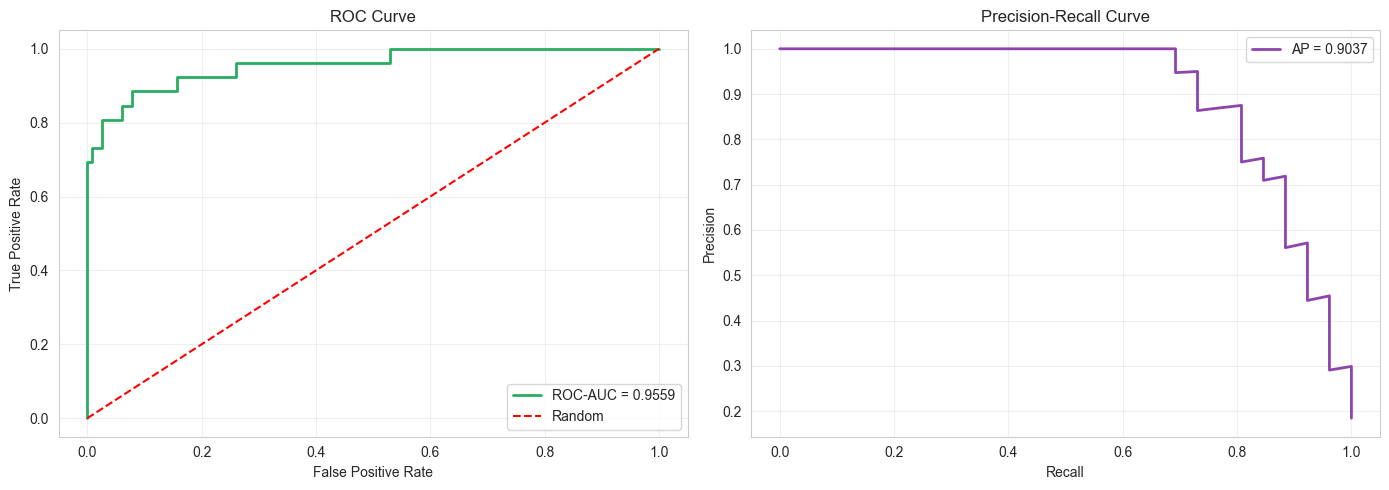

In [ ]:
# ROC and Precision-Recall curves
binary_y_test = (y_test == 'infiltrating lobular carcinoma').astype(int)
fpr, tpr, _ = roc_curve(binary_y_test, y_pred_proba)
precision_curve, recall_curve, _ = precision_recall_curve(binary_y_test, y_pred_proba)
avg_precision = average_precision_score(binary_y_test, y_pred_proba)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(fpr, tpr, color='#27ae60', lw=2, label=f'ROC-AUC = {roc_auc:.4f}')
axes[0].plot([0, 1], [0, 1], 'r--', lw=1.5, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

axes[1].plot(recall_curve, precision_curve, color='#8e44ad', lw=2, label=f'AP = {avg_precision:.4f}')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

TOP 20 PCA COMPONENTS BY COEFFICIENT MAGNITUDE
Positive coefficients → favor lobular carcinoma
Negative coefficients → favor ductal carcinoma


,component,coefficient,abs_coefficient
0,PC49,-0.184965,0.184965
1,PC2,0.162446,0.162446
2,PC70,0.156248,0.156248
3,PC32,0.155681,0.155681
4,PC89,0.152357,0.152357
5,PC46,-0.148200,0.148200
6,PC41,-0.142506,0.142506
7,PC243,0.117823,0.117823
8,PC130,0.116282,0.116282
9,PC31,0.113930,0.113930


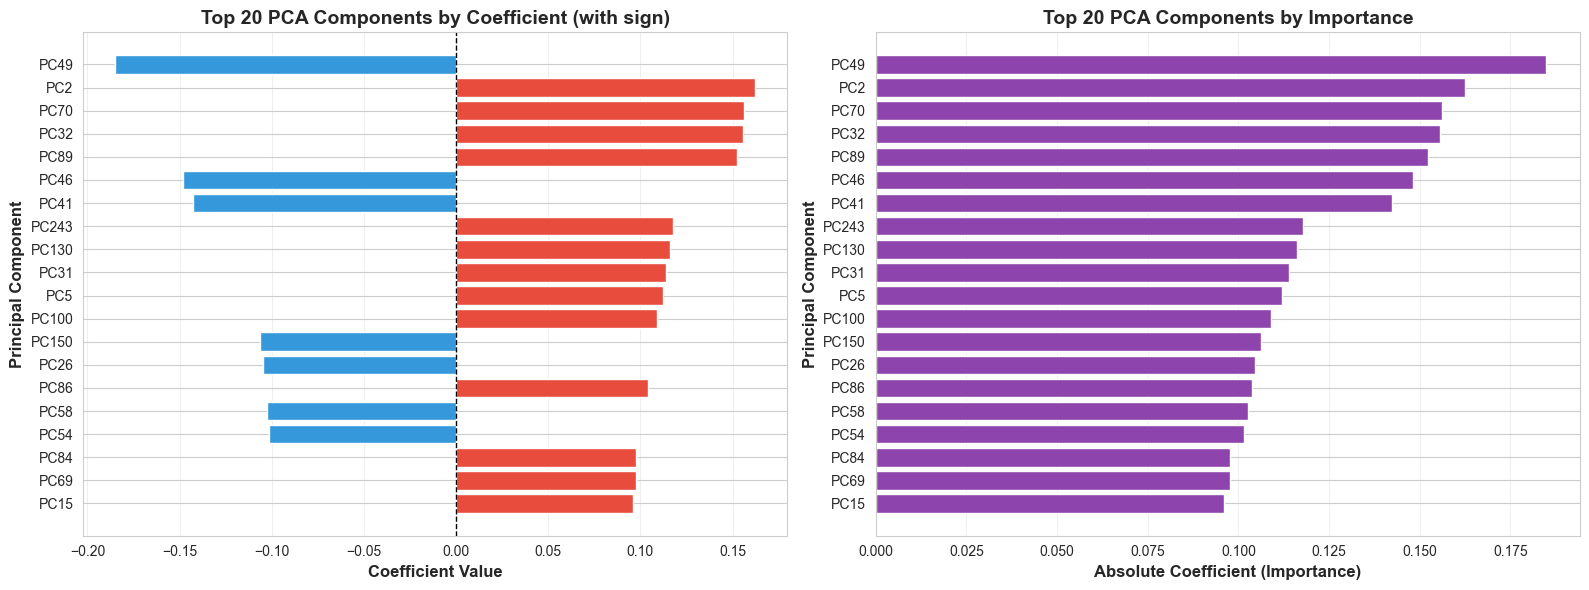

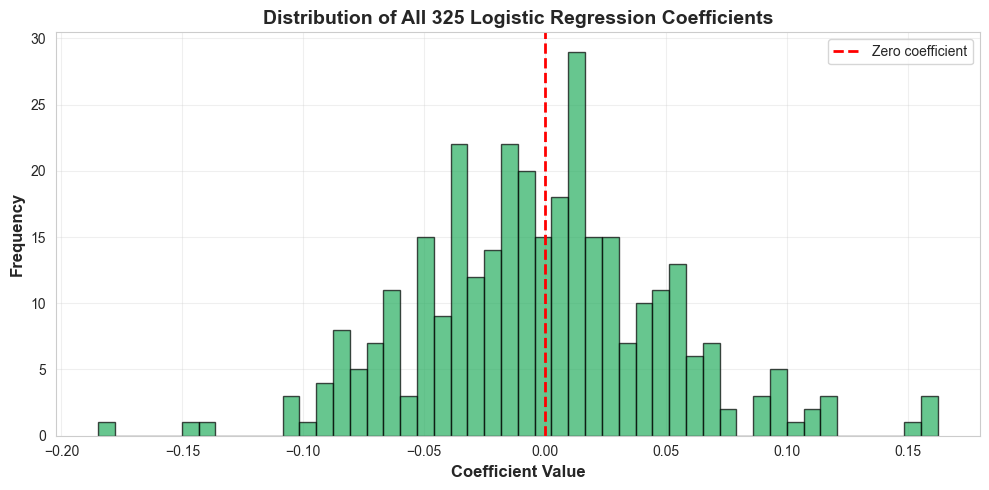

In [ ]:
# Top PCA components by coefficient magnitude
coefficients = tuned_model.named_steps['classifier'].coef_[0]

# Get absolute values for importance ranking
abs_coefficients = np.abs(coefficients)
top_indices = np.argsort(abs_coefficients)[::-1][:20]

top_components = [f'PC{i+1}' for i in top_indices]
top_coefs = coefficients[top_indices]
top_abs_coefs = abs_coefficients[top_indices]

importance_df = pd.DataFrame({
    'component': top_components,
    'coefficient': top_coefs,
    'abs_coefficient': top_abs_coefs
}).sort_values('abs_coefficient', ascending=False)

top_n = 20
print('='*80)
print(f'TOP {top_n} PCA COMPONENTS BY COEFFICIENT MAGNITUDE')
print('='*80)
print('Positive coefficients → favor lobular carcinoma')
print('Negative coefficients → favor ductal carcinoma')
print('='*80)
display(importance_df.head(top_n))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of top coefficients (with sign)
colors = ['#e74c3c' if c > 0 else '#3498db' for c in top_coefs]
axes[0].barh(range(len(top_coefs)), top_coefs, color=colors)
axes[0].set_yticks(range(len(top_components)))
axes[0].set_yticklabels(top_components)
axes[0].set_xlabel('Coefficient Value', fontsize=12, weight='bold')
axes[0].set_ylabel('Principal Component', fontsize=12, weight='bold')
axes[0].set_title('Top 20 PCA Components by Coefficient (with sign)', fontsize=14, weight='bold')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Bar plot of absolute coefficients (importance)
axes[1].barh(range(len(top_abs_coefs)), top_abs_coefs, color='#8e44ad')
axes[1].set_yticks(range(len(top_components)))
axes[1].set_yticklabels(top_components)
axes[1].set_xlabel('Absolute Coefficient (Importance)', fontsize=12, weight='bold')
axes[1].set_ylabel('Principal Component', fontsize=12, weight='bold')
axes[1].set_title('Top 20 PCA Components by Importance', fontsize=14, weight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Additional: Distribution of all coefficients
plt.figure(figsize=(10, 5))
plt.hist(coefficients, bins=50, color='#27ae60', edgecolor='black', alpha=0.7)
plt.xlabel('Coefficient Value', fontsize=12, weight='bold')
plt.ylabel('Frequency', fontsize=12, weight='bold')
plt.title(f'Distribution of All {len(coefficients)} Logistic Regression Coefficients', fontsize=14, weight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero coefficient')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 6. Final Summary

In [ ]:
print('\n' + '='*80)
print('FINAL SUMMARY')
print('='*80)

best_params = grid_search.best_params_

print('Dataset:')
print(f'  Samples: {len(df):,}')
print(f'  Features (original): {len(feature_cols):,}')
print(f'  PCA components used: {n_components_95} (95% variance)')

print('\nModeling:')
print('  Algorithm: Logistic Regression on PCA components')
print('  Feature transformation: PCA (decorrelated components)')
print(f'  Regularization: {best_params.get("classifier__penalty", "N/A")}')
print(f'  C parameter: {best_params.get("classifier__C", "N/A")}')
print('  Hyperparameter search: GridSearchCV (stratified 5-fold CV)')
print(f'  Best CV ROC-AUC: {grid_search.best_score_:.4f}')

print('\nTest performance:')
print(f'  Accuracy: {accuracy:.4f}')
print(f'  Precision (macro): {precision_macro:.4f}')
print(f'  Recall (macro): {recall_macro:.4f}')
print(f'  F1-score (macro): {f1_macro:.4f}')
print(f'  ROC-AUC: {roc_auc:.4f}')

print('\nKey advantages of this approach:')
print('  ✅ PCA components are decorrelated → optimal for linear models')
print('  ✅ Faster training than Random Forest')
print('  ✅ Native probability estimates for ROC curve')
print('  ✅ Interpretable coefficients show component importance')

print('\nInterpretation:')
if roc_auc >= 0.85:
    print('  ✅ Excellent separation between histological types.')
elif roc_auc >= 0.75:
    print('  ✅ Good discrimination with room for further improvement.')
elif roc_auc >= 0.65:
    print('  ⚠️ Acceptable performance; consider additional feature engineering.')
else:
    print('  ⚠️ Model performance is limited; investigate alternative models and preprocessing.')

print('\n' + '='*80)
print('Analysis complete!')
print('='*80)


FINAL SUMMARY
Dataset:
  Samples: 705
  Features (original): 1,936
  PCA components used: 325 (95% variance)

Modeling:
  Algorithm: Logistic Regression on PCA components
  Feature transformation: PCA (decorrelated components)
  Regularization: l2
  C parameter: 0.01
  Hyperparameter search: GridSearchCV (stratified 5-fold CV)
  Best CV ROC-AUC: 0.9201

Test performance:
  Accuracy: 0.9220
  Precision (macro): 0.8670
  Recall (macro): 0.8778
  F1-score (macro): 0.8722
  ROC-AUC: 0.9559

Key advantages of this approach:
  ✅ PCA components are decorrelated → optimal for linear models
  ✅ Faster training than Random Forest
  ✅ Native probability estimates for ROC curve
  ✅ Interpretable coefficients show component importance

Interpretation:
  ✅ Excellent separation between histological types.

Analysis complete!
